In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, roc_auc_score, precision_score
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, LeaveOneOut, StratifiedKFold, cross_val_score, learning_curve
from scikeras.wrappers import KerasClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
import random
import glob
import os


import warnings
warnings.filterwarnings('ignore')

In [2]:
loan_approval = pd.read_csv('./archive/Loan.csv')
loan_approval.shape

(20000, 36)

In [3]:
loan_approval['ApplicationDate'] = pd.to_datetime(loan_approval['ApplicationDate'])
loan_approval['ApplicationYear'] = loan_approval['ApplicationDate'].dt.year
loan_approval['ApplicationMonth'] = loan_approval['ApplicationDate'].dt.month
loan_approval = loan_approval.drop(columns=['ApplicationDate'])  #

In [4]:
X = loan_approval.drop(columns=['LoanApproved', 'RiskScore'])
y = loan_approval['LoanApproved']

In [5]:
categorical_cols = ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 
                    'HomeOwnershipStatus', 'LoanPurpose']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

In [6]:
# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Normalize numerical data
        ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical data
    ])

In [7]:
X_preprocessed = preprocessor.fit_transform(X)

In [8]:
random_split = ShuffleSplit(n_splits=30, test_size=0.2)
kfold = KFold(n_splits=10, shuffle=True)
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True)
loo = LeaveOneOut()

In [9]:
def scores_split(model, X, y, cv=None, test_size=None, feature_selection=False):
    selector = SelectKBest(f_classif, k=5)
    if cv is None:
        if test_size is None:
            print("Not Using Train-Test Split")
            X_train = X
            X_test = X
            y_train = y
            y_test = y
        else:
            print("Using Train-Test Split")
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

            # Apply feature selection only to training data
        if feature_selection:
            X_train = selector.fit_transform(X_train, y_train)
            X_test = selector.transform(X_test)  # Transform test set using the same selector
            
        # Train the model on the training data
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.2, validation_data = (X_test,y_test))
        model_result = pd.DataFrame(model.history.history)
        model_result.plot()
        
        # Predict on the test data
        y_pred_test = (model.predict(X_test) > 0.5).astype("int32")
        
        # Calculate and display performance metrics on the test set
        train_test_accuracy = accuracy_score(y_test, y_pred_test)
        train_test_f1 = f1_score(y_test, y_pred_test, average='weighted')
        train_test_recall = recall_score(y_test, y_pred_test)
        train_test_precision = precision_score(y_test, y_pred_test)
        
        print('Accuracy: ',train_test_accuracy)
        print('F1: ',train_test_f1)
        print('Recall: ', train_test_recall)
        print('Precission: ', train_test_precision)
        
        # Plot confusion matrix for the test set
        display = confusion_matrix(y_test, y_pred_test)
        display = display / display.sum(axis=1, keepdims=True) * 100
        
        plt.figure(figsize=(6, 4))
        sns.heatmap(display, annot=True, fmt=".2f", cmap='Blues', 
                    xticklabels=['Predicted 0', 'Predicted 1'], 
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel("Predicted Labels")
        plt.ylabel("Actual Labels")
        plt.title("Confusion Matrix (Percentages)")
        plt.show()

    else:
        model = KerasClassifier(build_fn=model, epochs=10, batch_size=32, verbose=0)
        print(f"Using Cross-Validation with {cv} folds")


        steps = []

        steps.append(('model', model))
        pipeline = Pipeline(steps)
        
        # Cross-validation scoring
        scores = ['accuracy', 'f1_weighted', 'recall_weighted', 'precision']
        colors = ['r', 'g', 'b', 'm']  # Different colors for each metric
        metric_results = {}
        
        for score in scores:
            if feature_selection:
                X = selector.fit_transform(X, y)
            cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=score, verbose=0)
            metric_results[score] = cv_scores  # Store the cross-validation scores
            print(f'{score}: {cv_scores.mean()}')

        plt.figure()
        
        for i, metric in enumerate(scores):
            plt.plot(range(1, len(metric_results[metric]) + 1),
                     metric_results[metric], label=metric.capitalize(),
                     color=colors[i])
            
        plt.title(f"Cross-Validation Scores ({cv} folds)")
        plt.xlabel("Fold Number")
        plt.ylabel("Score")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()

In [10]:
input_dim = X_preprocessed.shape[1]

In [11]:
model = Sequential()

model.add(Dense(20, input_shape=(input_dim,), activation='relu'))
model.add(Dropout(0.5))  # Regularization
model.add(BatchNormalization())
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,561 (6.10 KB)

 Trainable params: 1,521 (5.94 KB)

 Non-trainable params: 40 (160.00 B)

Not Using Train-Test Split
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
Accuracy:  0.9661
F1:  0.9661
Recall:  0.9290794979079497
Precission:  0.9290794979079497


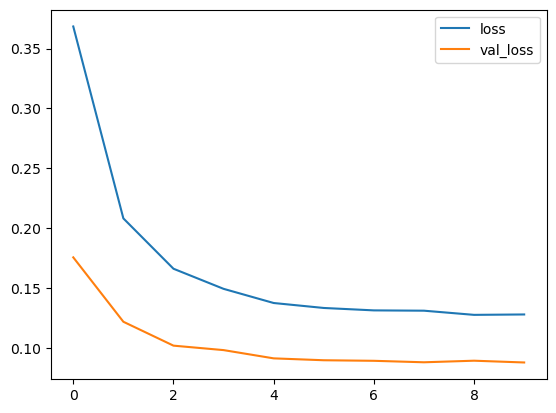

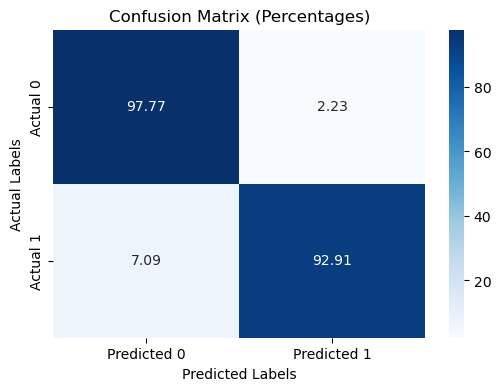

In [12]:
scores_split(model, X_preprocessed, y)

Using Train-Test Split
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
Accuracy:  0.96425
F1:  0.9640724434596402
Recall:  0.9109481403876375
Precission:  0.937466307277628


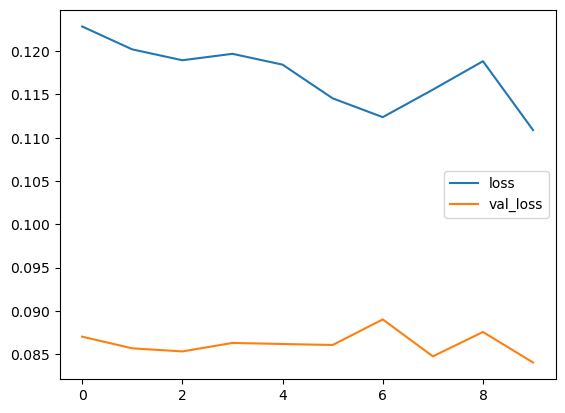

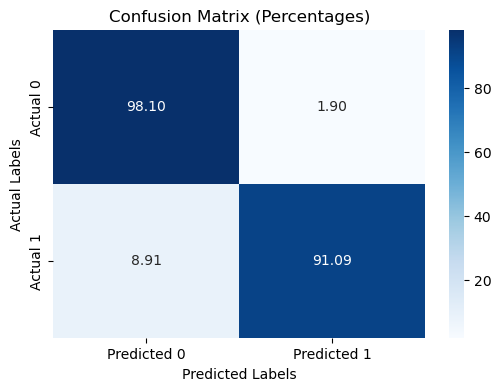

In [13]:
scores_split(model, X_preprocessed, y, test_size=0.4)

Using Cross-Validation with ShuffleSplit(n_splits=30, random_state=None, test_size=0.2, train_size=None) folds
accuracy: 0.9663
f1_weighted: 0.9665749138974465
recall_weighted: 0.9658583333333335
precision: 0.9252787003236673


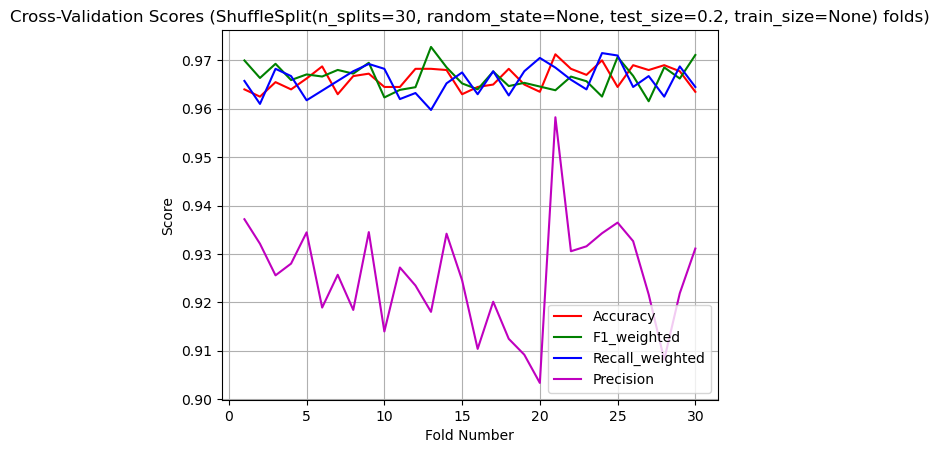

In [14]:
scores_split(model, X_preprocessed, y, cv=random_split)

Using Cross-Validation with KFold(n_splits=10, random_state=None, shuffle=True) folds
accuracy: 0.9661500000000001
f1_weighted: 0.9659130224888335
recall_weighted: 0.9656
precision: 0.9210892461662679


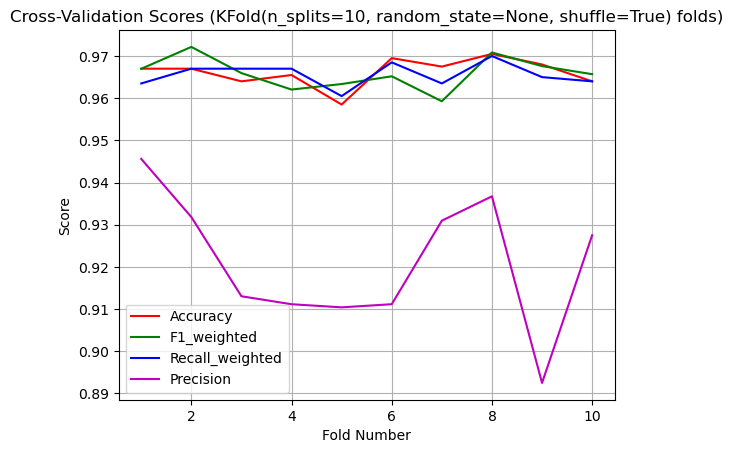

In [15]:
scores_split(model, X_preprocessed, y, cv=kfold)

In [16]:
# scores_split(model, X_preprocessed, y, cv=loo)